<a href="https://colab.research.google.com/github/KurniaKhaikal/BreastCancerIDC-CNN/blob/khaikal/NewS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"khaikal","key":"9e492a7553b8e713debda6f4f6810151"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:49<00:00, 42.6MB/s]
100% 3.10G/3.10G [00:49<00:00, 66.9MB/s]


In [4]:
import os
import zipfile

local_zip = '/content/breast-histopathology-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

In [12]:
mypaths=[]
for name in glob('/content/input/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])

['/content/input/IDC_regular_ps50_idx5/10264', '/content/input/IDC_regular_ps50_idx5/15515', '/content/input/IDC_regular_ps50_idx5/13617', '/content/input/IDC_regular_ps50_idx5/9291', '/content/input/IDC_regular_ps50_idx5/14156']


In [13]:
mp=mypaths[60:120]
imagePatches=[]
for i in mp:
    imagePatches+=glob(i+'/*/*.png', recursive=True)

In [15]:
print('total no. of images selected from total images is '+str(len(imagePatches)))
#imagePatches[60:90]

total no. of images selected from total images is 54364


In [16]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [17]:
print('Among them, '+str(len(class0))+' is clss0 and '+str(len(class1))+' is class1')

Among them, 38196 is clss0 and 16168 is class1


In [18]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))
len(sampled_class0)

16168

In [19]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
      if i.endswith('.png'):
        img = cv2.imread(i ,cv2.IMREAD_COLOR)
        img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        img_re=img_sized/255.0
        img_arrays.append([img_re, label])
    return img_arrays

In [20]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)
print('done')

done


In [21]:
print(len(class0_array))
print(len(class1_array))

16168
16168


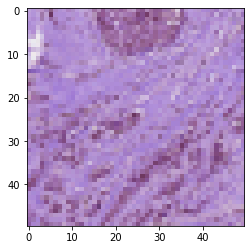

In [22]:
plt.imshow(class1_array[10][0])

In [23]:
combined_data = np.concatenate((class0_array, class1_array))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [24]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [25]:
X = np.array(X).reshape(-1, 50, 50, 3)

In [26]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25868, 50, 50, 3) (6468, 50, 50, 3) (25868, 2) (6468, 2)


In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(50,50,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(9216,input_shape=(12544,), activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [29]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall','Precision']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 100)       2800      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 100)      400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       102656    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 256)      1024      
 hNormalization)                                                 
                                                        

In [31]:
history=model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs=20)

Epoch 1/20
809/809 [==============================] - 821s 1s/step - loss: 0.5345 - accuracy: 0.7640 - recall: 0.7453 - precision: 0.7418 - val_loss: 0.4216 - val_accuracy: 0.8171 - val_recall: 0.8135 - val_precision: 0.8194
Epoch 2/20
809/809 [==============================] - 820s 1s/step - loss: 0.4555 - accuracy: 0.8094 - recall: 0.8035 - precision: 0.8012 - val_loss: 0.4049 - val_accuracy: 0.8271 - val_recall: 0.8231 - val_precision: 0.8299
Epoch 3/20
809/809 [==============================] - 823s 1s/step - loss: 0.4354 - accuracy: 0.8160 - recall: 0.8097 - precision: 0.8103 - val_loss: 0.3945 - val_accuracy: 0.8316 - val_recall: 0.8309 - val_precision: 0.8341
Epoch 4/20
809/809 [==============================] - 821s 1s/step - loss: 0.4137 - accuracy: 0.8264 - recall: 0.8224 - precision: 0.8202 - val_loss: 0.3885 - val_accuracy: 0.8352 - val_recall: 0.8336 - val_precision: 0.8377
Epoch 5/20
809/809 [==============================] - 812s 1s/step - loss: 0.4074 - accuracy: 0.8275

In [32]:
e=model.evaluate(X_test,y_test)

203/203 [==============================] - 41s 201ms/step - loss: 0.3646 - accuracy: 0.8502 - recall: 0.8496 - precision: 0.8511


In [33]:
print(e[0])

0.3646397292613983


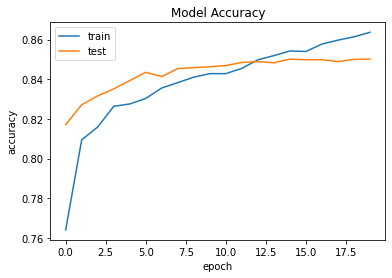

In [34]:
import matplotlib.pyplot as plt

#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

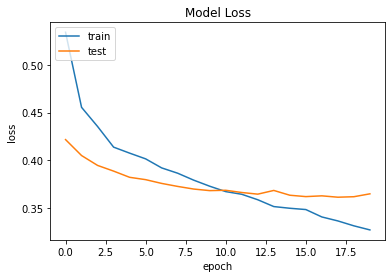

In [35]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred=model.predict(X_test)

In [37]:
y_pred[21]

array([0.23759884, 0.7810675 ], dtype=float32)

In [38]:
y_test[21]

array([0., 1.], dtype=float32)

In [39]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [40]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)

In [41]:
Y_pred[0]

1

In [42]:
Y_test[0]

1

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['IDC(-)','IDC(+)']))

Confusion Matrix
[[2730  510]
 [ 459 2769]]
Classification Report
              precision    recall  f1-score   support

      IDC(-)       0.86      0.84      0.85      3240
      IDC(+)       0.84      0.86      0.85      3228

    accuracy                           0.85      6468
   macro avg       0.85      0.85      0.85      6468
weighted avg       0.85      0.85      0.85      6468

